In [ ]:
import requests
from bs4 import BeautifulSoup as bs 

import json 
import pandas as pd 

import hdfs 

# [다음 영화 실시간 예매율](https://search.daum.net/search?w=tot&DA=TMZ&q=%EC%98%81%ED%99%94%EC%88%9C%EC%9C%84)

### 다음 영화 실시간 예매율 크롤링 

In [ ]:
url = "https://search.daum.net/search?w=tot&DA=TMZ&q=%EC%98%81%ED%99%94%EC%88%9C%EC%9C%84"
custom_header = {
    "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36",
    "referer": "https://www.google.com/"
}
response = requests.get(url, headers=custom_header)
response.raise_for_status()
response.status_code

### BeautifulSoup을 이용하여 HTML 파싱

In [ ]:
soup = bs(response.text, "html.parser")
soup

### 실시간 예매 영화 리스트 추출 

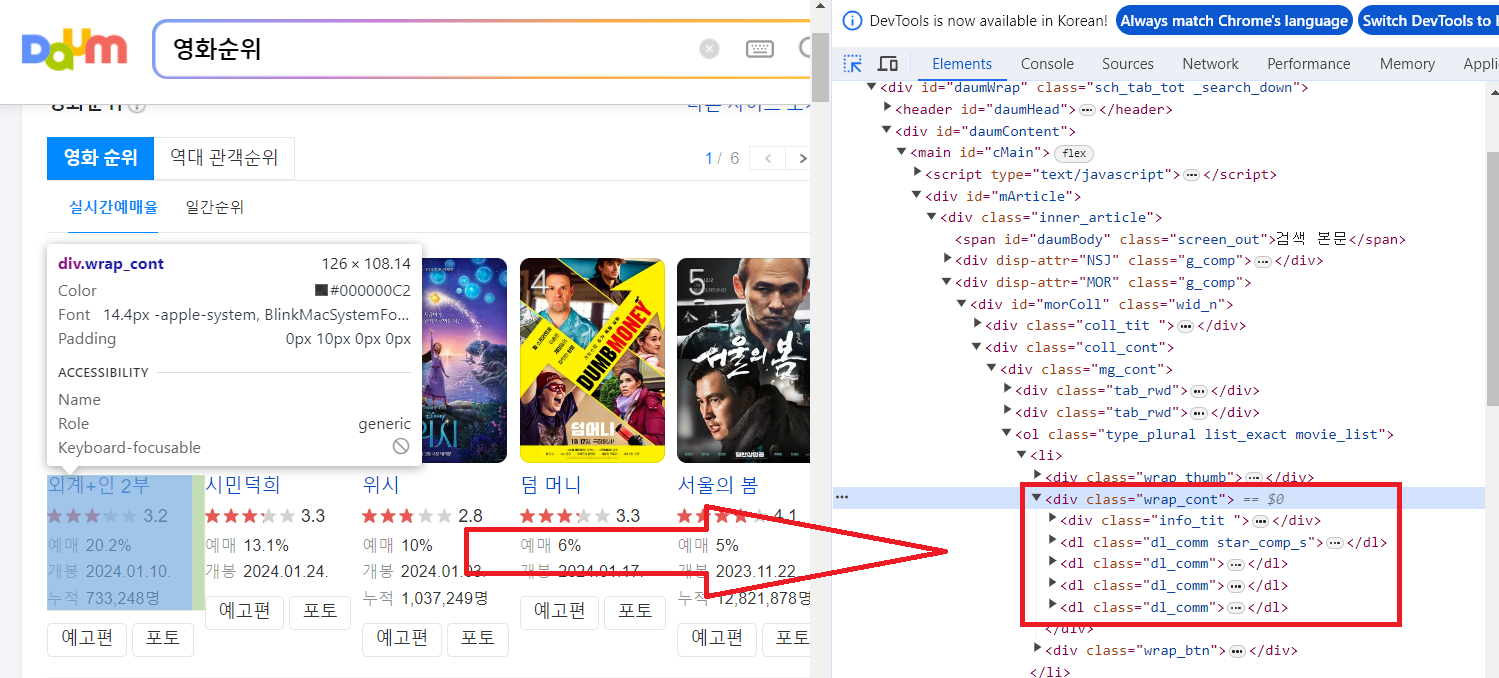

In [ ]:
ol_list = soup.find_all('div', class_='wrap_cont')
len(ol_list) # 실시간 예매 영화리스트 수 

In [ ]:
title = ol_list[0].find_all('a', class_='tit_main')[0].text # 제목
rate = ol_list[0].find_all('em', class_='rate')[0].text # 평점
reservation_rate = ol_list[0].find_all('dd', class_='cont')[0].text # 예매율
release_date = ol_list[0].find_all('dd', class_='cont')[1].text # 개봉일자
attendance_count = ol_list[0].find_all('dd', class_='cont')[2].text # 누적관객수

In [ ]:
title, rate, reservation_rate, release_date, attendance_count

### 실시간 예매 영활 리스트 추출 함수 

In [ ]:
def get_movies(soup):
    movies = []
    html_movies = soup.find_all('div', class_='wrap_cont')
    for _html in html_movies:
        _title = _html.find_all('a', class_='tit_main')
        if not len(_title):
            continue # 제목이 없는 경우에는 제외 

        _rate = _html.find_all('em', class_='rate')
        _lst = _html.find_all('dd', class_='cont')
        movies.append({
            'title' : _title[0].text # 제목
            , 'rate' : _rate[0].text if len(_rate) > 0 else '0.0' # 평점
            , 'reservation_rate' : _lst[0].text # 예매율
            , 'release_date' : _lst[1].text # 개봉일자
            , 'attendance_count' : _lst[2].text if len(_lst) > 2 else '0명'     # 누적관객수
        })

    return movies

In [ ]:
movies = get_movies(soup)
print(len(movies))
movies[0]

### 데이터프레임으로 변환 

In [ ]:
df_movies = pd.DataFrame(movies)
df_movies.head()

In [ ]:
df_movies.to_parquet('temp.parquet', engine='pyarrow', index=False)

In [ ]:
df_parquet = pd.read_parquet('temp.parquet', engine='pyarrow')
df_parquet.head()

In [14]:
df_movies.to_json('temp.json',orient='records')

In [15]:
df_json = pd.read_json('temp.json')
df_json.head()

,title,rate,reservation_rate,release_date,attendance_count
0,외계+인 2부,3.2,21.5%,2024.01.10.,"733,248명"
1,시민덕희,3.2,14.1%,2024.01.24.,0명
2,위시,2.8,10.3%,2024.01.03.,"1,037,227명"
3,덤 머니,3.3,5.5%,2024.01.17.,0명
4,서울의 봄,4.1,5.1%,2023.11.22.,"12,821,872명"
